<a href="https://colab.research.google.com/github/ananda1996ai/ML-Solutions-for-Donors-Choose-Acceptance-Prediction/blob/master/DT_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree Experiment

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import re
import os
import pickle

nltk.download('stopwords')
from nltk.corpus import stopwords

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import math

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from collections import Counter
from tqdm import tqdm

from scipy import sparse

from sklearn.externals import joblib

import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from numpy.random import seed
seed(1)

from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

from prettytable import PrettyTable
from prettytable import ALL

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


## 1. Getting Data

### 1.1 Load Datasets

In [0]:
project_data = pd.read_csv("/content/drive/My Drive/Assignment_2 drive dwnld/train_data.csv")
resource_data = pd.read_csv("/content/drive/My Drive/Assignment_2 drive dwnld/resources.csv")

price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
dataset = pd.merge(project_data, price_data, on='id', how='left')

dataset.shape

(109248, 19)

In [0]:
dataset.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,154.6,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,299.0,1


### 1.2 Dataset Cleaning and pre-processing

#### 1.2.1 Dropping irrelevant data

In [0]:
#For the purposes of classification, the columns 'unnamed', 'id', and 'teacher_id' must be dropped as they are unique for each record and will cause over-fitting.
#For classification, we'll consider only numerical features, categorical features, and text festures. Thus we also drop date-time information.

dataset.drop(['Unnamed: 0', 'id', 'teacher_id', 'project_submitted_datetime'], axis=1, inplace=True)

#As KNN is not suitable for large datasets, we downsample to 50K points from the original dataset.

dataset = resample(dataset, n_samples=50000, replace=False, stratify=dataset['project_is_approved'].values)
dataset = dataset.reset_index()
dataset.drop(['index'], axis=1, inplace=True)

In [0]:
print(dataset.shape)
dataset.head(2)

(50000, 15)


,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity
0,Mrs.,TX,Grades PreK-2,"Health & Sports, Literacy & Language","Health & Wellness, Literature & Writing",Wiggle While You Learn: Flexible Seating Optio...,My second graders have learned to work coopera...,"In today's classroom, we as teachers cater to ...",NaN,NaN,My students need flexible seating options that...,6,1,291.30,16
1,Mrs.,LA,Grades PreK-2,"Literacy & Language, Applied Learning","Literacy, Other",Autism Listens,"are completely amazing, and teach me everyday!...",In an Autism classroom we model all day to the...,NaN,NaN,My students need a Listening Center to help br...,0,1,367.99,4


#### 1.2.2 Text pre-processing

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
  # specific
  phrase = re.sub(r"won't", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase

sw = set(stopwords.words('english')) #Using NLTK list of stopwords.

#PRE-PROCESSING ON ESSAYS

dataset["essay"] = dataset["project_essay_1"].map(str) + dataset["project_essay_2"].map(str) + dataset["project_essay_3"].map(str) + dataset["project_essay_4"].map(str)

dataset.drop(['project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4'], axis=1, inplace=True)

preprocessed_essays = []
for sentence in tqdm(dataset['essay'].values):
  sent = decontracted(sentence)
  sent = sent.replace('\\r', ' ')
  sent = sent.replace('\\"', ' ')
  sent = sent.replace('\\n', ' ')
  sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
  # https://gist.github.com/sebleier/554280
  sent = ' '.join(w for w in sent.split() if w not in sw)
  preprocessed_essays.append(sent.lower().strip())
    
dataset["essay"] = preprocessed_essays  

100%|██████████| 50000/50000 [00:07<00:00, 7118.71it/s]


In [0]:
#PRE-PROCESSING ON TITLES

preprocessed_titles = []

for sentence in tqdm(dataset['project_title'].values):
  sent = decontracted(sentence)
  sent = sent.replace('\\r', ' ')
  sent = sent.replace('\\"', ' ')
  sent = sent.replace('\\n', ' ')
  sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
  # https://gist.github.com/sebleier/554280
  sent = ' '.join(w for w in sent.split() if w not in sw)
  preprocessed_titles.append(sent.lower().strip())
  
dataset["project_title"] = preprocessed_titles

100%|██████████| 50000/50000 [00:00<00:00, 75475.27it/s]


In [0]:
#PRE_PROCESSING ON RESOURCE SUMMARY

preprocessed_summary = []

for sentence in tqdm(dataset['project_resource_summary'].values):
  sent = decontracted(sentence)
  sent = sent.replace('\\r', ' ')
  sent = sent.replace('\\"', ' ')
  sent = sent.replace('\\n', ' ')
  sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
  # https://gist.github.com/sebleier/554280
  sent = ' '.join(w for w in sent.split() if w not in sw)
  preprocessed_summary.append(sent.lower().strip())
  
dataset['project_resource_summary'] = preprocessed_summary

100%|██████████| 50000/50000 [00:01<00:00, 47437.19it/s]


#### 1.2.3 Categorical data cleaning

In [0]:
#Cleaning TEACHER_PREFIXES

dataset['teacher_prefix'].fillna('NA', inplace=True)
dataset['teacher_prefix'] = dataset['teacher_prefix'].apply(lambda s: s.replace('.', ''))

In [0]:
#Cleaning PROJECT_GRADE_CATEGORIES

dataset['project_grade_category'] = dataset['project_grade_category'].apply(lambda s: re.sub(r'[\s\-]+', '_', s))

In [0]:
#Cleaning PROJECT_SUBJECT_CATEGORIES

cat_list = []
for category in tqdm(dataset['project_subject_categories'].values):
  temp = ""
  for j in category.split(','):
    
      if 'The' in j.split(): 
          j=j.replace('The','')
          
      j = j.replace(' ','')
      
      temp+=j.strip()+" "
      
      temp = temp.replace('&','_')
      
  cat_list.append(temp.strip())
  
dataset['clean_categories'] = cat_list
dataset.drop('project_subject_categories', axis=1, inplace=True)

100%|██████████| 50000/50000 [00:00<00:00, 460428.82it/s]


In [0]:
#Cleaning PROJECT_SUBJECT_SUBCATEGORY

subcat_list = []
for subcategory in tqdm(dataset['project_subject_subcategories'].values):
  temp = ""
  for j in subcategory.split(','):
    
      if 'The' in j.split(): 
          j=j.replace('The','')
          
      j = j.replace(' ','')
      
      temp+=j.strip()+" "
      
      temp = temp.replace('&','_')
      
  subcat_list.append(temp.strip())
  
dataset['clean_subcategories'] = subcat_list
dataset.drop('project_subject_subcategories', axis=1, inplace=True)

100%|██████████| 50000/50000 [00:00<00:00, 443378.14it/s]


In [0]:
dataset.head(3)

,teacher_prefix,school_state,project_grade_category,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,essay,clean_categories,clean_subcategories
0,Mrs,TX,Grades_PreK_2,wiggle while you learn flexible seating option...,my students need flexible seating options incl...,6,1,291.30,16,my second graders learned work cooperatively w...,Health_Sports Literacy_Language,Health_Wellness Literature_Writing
1,Mrs,LA,Grades_PreK_2,autism listens,my students need listening center help broaden...,0,1,367.99,4,completely amazing teach everyday they bravely...,Literacy_Language AppliedLearning,Literacy Other
2,Ms,CA,Grades_6_8,keep me active,my students need sports equipment keep active ...,33,1,78.97,16,our students come diverse backgrounds over 90 ...,Health_Sports,Gym_Fitness


In [0]:
dataset.shape

(50000, 12)

#### 1.2.4 Cleaning numerical data

In [0]:
#Checking if any of the numerical features have missing values...
isnan = []
for f in ('teacher_number_of_previously_posted_projects', 'price', 'quantity'):
  isnan.append(dataset[f].isna().values.any())
  
any(isnan)

False

Thus we do not have any missing values in numerical data. No cleaning required.

### 1.3 Divide data into Train, Test using Stratified Sampling

In [0]:
train_df = resample(dataset, n_samples=40000, replace=False, stratify=dataset['project_is_approved'].values)

train_df.shape

(40000, 12)

In [0]:
dataset_idx = pd.Index(dataset.index.values)
train_idx = pd.Index(train_df.index.values)
rem_idx = dataset_idx.difference(train_idx)

test_df = dataset.iloc[rem_idx]

test_df.shape

(10000, 12)

### 1.4 Balance the Train data

In [0]:
train_df['project_is_approved'].value_counts()

1    33943
0     6057
Name: project_is_approved, dtype: int64

In [0]:
#Now we balance the dataset by upsampling the minority class points. 

minor_data = train_df[train_df['project_is_approved']==0]
major_data = train_df[train_df['project_is_approved']==1]

minor_data_upsampled = resample(minor_data, n_samples=33943)   #Equal to the size of major class

balanced_train_df = pd.concat([major_data, minor_data_upsampled])

#Now, to set the dataset to a mangeable size, we sample 100K points from the balanced train data stratified on class labels.
train_df = resample(balanced_train_df, n_samples=40000, replace=False, stratify=balanced_train_df['project_is_approved'].values)

In [0]:
#Now the train dataset is exactly balanced

train_df['project_is_approved'].value_counts()

1    20000
0    20000
Name: project_is_approved, dtype: int64

In [0]:
train_df.head(2)

,teacher_prefix,school_state,project_grade_category,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,essay,clean_categories,clean_subcategories
26419,Teacher,NC,Grades_6_8,hand bound interactive journals,my students need f handmade book binding tools...,2,1,34.09,43,as teacher large expanding school district stu...,AppliedLearning,College_CareerPrep EarlyDevelopment
29100,Ms,MI,Grades_9_12,read like champion,my students need classroom library foster love...,1,1,453.96,21,this fall i walking new school first chemistry...,Math_Science Literacy_Language,AppliedSciences Literacy


## Features for classification

For classification, we are going to consider

   - school_state : categorical data (One-hot encoded)
   - clean_categories : categorical data (One-hot encoded)
   - clean_subcategories : categorical data (One-hot encoded)
   - project_grade_category : categorical data (One-hot encoded)
   - teacher_prefix : categorical data (One-hot encoded)

   - **project_title : text data (BOW, TFIDF, AVG_W2V, TFIDF_W2V)**
   - **essay : text data (BOW, TFIDF, AVG_W2V, TFIDF_W2V)**
   
   - quantity : numerical (optional) (Vectorized)
   - teacher_number_of_previously_posted_projects : numerical (Vectorized)
   - price : numerical (Vectorized)

## 2. Encoding Data

### 2.1 Create all encoders using Train data

#### 2.1.1 Vectorizers for categorical data (One-hot encoders)

In [0]:
#Vectorizer for CLEAN_CATEGORIES

cat_list = set()

for categories in train_df['clean_categories'].values:
  for word in categories.split():
    cat_list.add(word)

cat_vectorizer = CountVectorizer(vocabulary=list(cat_list), lowercase=False, binary=True)
cat_vectorizer.fit(train_df['clean_categories'].values)
print(cat_vectorizer.get_feature_names())

['SpecialNeeds', 'Math_Science', 'AppliedLearning', 'History_Civics', 'Care_Hunger', 'Health_Sports', 'Warmth', 'Music_Arts', 'Literacy_Language']


In [0]:
#Vectorizer for CLEAN_SUBCATEGORIES

subcat_list = set()

for subcategories in train_df['clean_subcategories'].values:
  for word in subcategories.split():
    subcat_list.add(word)

subcat_vectorizer = CountVectorizer(vocabulary=list(subcat_list), lowercase=False, binary=True)
subcat_vectorizer.fit(train_df['clean_subcategories'].values)
print(subcat_vectorizer.get_feature_names())

['TeamSports', 'Other', 'Health_LifeScience', 'CharacterEducation', 'College_CareerPrep', 'PerformingArts', 'EnvironmentalScience', 'Civics_Government', 'NutritionEducation', 'Economics', 'VisualArts', 'Gym_Fitness', 'SocialSciences', 'EarlyDevelopment', 'Music', 'ParentInvolvement', 'Literacy', 'CommunityService', 'Warmth', 'Mathematics', 'Literature_Writing', 'ESL', 'Care_Hunger', 'AppliedSciences', 'FinancialLiteracy', 'SpecialNeeds', 'History_Geography', 'Health_Wellness', 'Extracurricular', 'ForeignLanguages']


In [0]:
#Vectorizer for PROJECT_GRADE_CATEGORIES

grades_list = set(train_df['project_grade_category'].values)

grade_vectorizer = CountVectorizer(vocabulary=list(grades_list), lowercase=False, binary=True)
grade_vectorizer.fit(train_df['project_grade_category'].values)
print(grade_vectorizer.get_feature_names())

['Grades_6_8', 'Grades_PreK_2', 'Grades_3_5', 'Grades_9_12']


In [0]:
#Vectorizer for SCHOOL_STATE

state_list = set(train_df['school_state'].values)

state_vectorizer = CountVectorizer(vocabulary=list(state_list), lowercase=False, binary=True)
state_vectorizer.fit(train_df['school_state'].values)
print(state_vectorizer.get_feature_names())

['KS', 'TN', 'MN', 'WI', 'SD', 'AZ', 'LA', 'NC', 'FL', 'CO', 'RI', 'NH', 'NY', 'NE', 'DC', 'ND', 'AR', 'MO', 'MI', 'NV', 'NJ', 'AK', 'WA', 'OH', 'DE', 'NM', 'VA', 'ME', 'TX', 'MS', 'MD', 'VT', 'IA', 'OR', 'AL', 'MA', 'ID', 'CT', 'CA', 'SC', 'IN', 'PA', 'OK', 'GA', 'IL', 'UT', 'KY', 'HI', 'WV', 'WY', 'MT']


In [0]:
#Vectorizer for TEACHER_PREFIX

prefix_list = set(train_df['teacher_prefix'].values)

pf_vectorizer = CountVectorizer(vocabulary=list(prefix_list), lowercase=False, binary=True)
pf_vectorizer.fit(train_df['teacher_prefix'].values)
print(pf_vectorizer.get_feature_names())

['Ms', 'Dr', 'Mrs', 'Teacher', 'Mr']


#### 2.1.2 Vectorizers for text data (BOW, TFIDF, AVG_W2V, TFIDF_W2V)

In [0]:
#BOW vectorizer for PROJECT_TITLE

vectorizer = CountVectorizer(min_df=5, max_features=500)
bow_vectrzr_title = vectorizer.fit(train_df['project_title'].values)

In [0]:
#BOW vectorizer for ESSAY

vectorizer = CountVectorizer(min_df=5, max_features=5000)
bow_vectrzr_essay = vectorizer.fit(train_df['essay'].values)

In [0]:
#TFIDF vectorizer for PROJECT_TITLE

vectorizer = TfidfVectorizer(min_df=5, max_features=500)
tfidf_vectrzr_title = vectorizer.fit(train_df['project_title'].values)

In [0]:
print(len(tfidf_vectrzr_title.get_feature_names()))

500


In [0]:
#TFIDF vectorizer for ESSAY

vectorizer = TfidfVectorizer(min_df=5, max_features=5000)
tfidf_vectrzr_essay = vectorizer.fit(train_df['essay'].values)

#### 2.1.3 Vectorizers for numerical data

In [0]:
#For PRICE

price_scalar = StandardScaler()
price_scalar.fit(train_df['price'].values.reshape(-1, 1))


#For QUANTITY

quantity_scalar = StandardScaler()
quantity_scalar.fit(train_df['quantity'].values.reshape(-1, 1))


#For TEACHER_NUMBER_OF_PREVIOUSLY_POSTED_PROJECTS

ppost_scalar = StandardScaler()
ppost_scalar.fit(train_df['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

StandardScaler(copy=True, with_mean=True, with_std=True)

### 2.2 Transform Train & Test data: Generate four training sets; Four val sets; Four Test sets

#### 2.2.1. Transforming categorical features

In [0]:
train_df_clean_categories = cat_vectorizer.transform(train_df['clean_categories'].values)
test_df_clean_categories = cat_vectorizer.transform(test_df['clean_categories'].values)

train_df_clean_subcategories = subcat_vectorizer.transform(train_df['clean_subcategories'].values)
test_df_clean_subcategories = subcat_vectorizer.transform(test_df['clean_subcategories'].values)

train_df_project_grade_category = grade_vectorizer.transform(train_df['project_grade_category'].values)
test_df_project_grade_category = grade_vectorizer.transform(test_df['project_grade_category'].values)

train_df_school_state = state_vectorizer.transform(train_df['school_state'].values)
test_df_school_state = state_vectorizer.transform(test_df['school_state'].values)

train_df_teacher_prefix = pf_vectorizer.transform(train_df['teacher_prefix'].values)
test_df_teacher_prefix = pf_vectorizer.transform(test_df['teacher_prefix'].values)

#### 2.2.2 Transforming (vectorizing) numerical features

In [0]:
train_df_price = price_scalar.transform(train_df['price'].values.reshape(-1, 1))
test_df_price = price_scalar.transform(test_df['price'].values.reshape(-1, 1))

train_df_quantity = quantity_scalar.transform(train_df['quantity'].values.reshape(-1, 1))
test_df_quantity = quantity_scalar.transform(test_df['quantity'].values.reshape(-1, 1))

train_df_pposts = ppost_scalar.transform(train_df['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
test_df_pposts = ppost_scalar.transform(test_df['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

#### 2.2.3 Transforming text data

In [0]:
#For PROJECT_TITLE

#BOW
title_train_bow = bow_vectrzr_title.transform(train_df['project_title'].values)
title_test_bow = bow_vectrzr_title.transform(test_df['project_title'].values)

#TFIDF
title_train_tfidf = tfidf_vectrzr_title.transform(train_df['project_title'].values)
title_test_tfidf = tfidf_vectrzr_title.transform(test_df['project_title'].values)

In [0]:
#For ESSAY

#BOW
essay_train_bow = bow_vectrzr_essay.transform(train_df['essay'].values)
essay_test_bow = bow_vectrzr_essay.transform(test_df['essay'].values)

#TFIDF
essay_train_tfidf = tfidf_vectrzr_essay.transform(train_df['essay'].values)
essay_test_tfidf = tfidf_vectrzr_essay.transform(test_df['essay'].values)

#### 2.2.4 Generating the sets of data

In [0]:
#SET_1: categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW)
train_set_1x = sparse.hstack((train_df_teacher_prefix, train_df_school_state, train_df_project_grade_category, train_df_clean_categories, train_df_clean_subcategories, train_df_price, train_df_quantity, train_df_pposts, title_train_bow, essay_train_bow)) 
train_set_1y = train_df['project_is_approved'].to_numpy()

test_set_1x = sparse.hstack((test_df_teacher_prefix, test_df_school_state, test_df_project_grade_category, test_df_clean_categories, test_df_clean_subcategories, test_df_price, test_df_quantity, test_df_pposts, title_test_bow, essay_test_bow)) 
test_set_1y = test_df['project_is_approved'].to_numpy()

In [0]:
#SET_2: categorical, numerical features + project_title(TFIDF) + preprocessed_essay (TFIDF)
train_set_2x = sparse.hstack((train_df_teacher_prefix, train_df_school_state, train_df_project_grade_category, train_df_clean_categories, train_df_clean_subcategories, train_df_price, train_df_quantity, train_df_pposts, title_train_tfidf, essay_train_tfidf))
train_set_2y = train_df['project_is_approved'].to_numpy()

test_set_2x = sparse.hstack((test_df_teacher_prefix, test_df_school_state, test_df_project_grade_category, test_df_clean_categories, test_df_clean_subcategories, test_df_price, test_df_quantity, test_df_pposts, title_test_tfidf, essay_test_tfidf))
test_set_2y = test_df['project_is_approved'].to_numpy()

In [0]:
print(train_set_1x.shape)
print(test_set_1x.shape)
print(train_set_2x.shape)
print(test_set_2x.shape)
print(train_set_1y.shape)
print(train_set_2y.shape)
print(test_set_1y.shape)
print(test_set_2y.shape)

(40000, 5602)
(10000, 5602)
(40000, 5602)
(10000, 5602)
(40000,)
(40000,)
(10000,)
(10000,)


## 3. Applying Decison Trees

### 3.1 Hyperparameter tuning and model selection

In [0]:
#For SET_1

dt_model = DecisionTreeClassifier()
parameters = {'max_depth':[1, 5, 10, 50], 'min_samples_split':[5, 10, 100, 500]}
clf = GridSearchCV(dt_model, parameters, cv=3, scoring='roc_auc', return_train_score=True, verbose=2, n_jobs=10)
clf.fit(train_set_1x, train_set_1y)

results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  48 out of  48 | elapsed:   33.3s finished


In [0]:
X = results['param_min_samples_split'].values
Y = results['param_max_depth'].values
Z_train = results['mean_train_score'].values
Z_test = results['mean_test_score'].values

train_trace = go.Scatter3d(x=X, y=Y, z=Z_train, name='Train')

cv_trace = go.Scatter3d(x=X, y=Y, z=Z_test, name='Cross Validation')

data = [train_trace, cv_trace]

layout = go.Layout(scene = dict(
        xaxis = dict(title='Min samples split'),
        yaxis = dict(title='max Depth'),
        zaxis = dict(title='Mean AUC scores'),))

fig = go.Figure(data=data, layout=layout)
fig.show(renderer="colab")

In [0]:
test_table = Z_test.reshape((4,4))
train_table = Z_train.reshape((4,4))
hyp_table = PrettyTable()
hyp_table.field_names = ['Max Depth \ Min Splits', '5', '10', '100', '500']
row_names = ['1', '15', '10', '50']

i=0
for s in row_names:
  hyp_table.add_row([s, "Train AUC: "+str(np.round(train_table[i][0], 4))+"\nTest AUC: "+str(np.round(test_table[i][0], 4)),
                        "Train AUC: "+str(np.round(train_table[i][1], 4))+"\nTest AUC: "+str(np.round(test_table[i][1], 4)),
                        "Train AUC: "+str(np.round(train_table[i][2], 4))+"\nTest AUC: "+str(np.round(test_table[i][2], 4)),
                        "Train AUC: "+str(np.round(train_table[i][3], 4))+"\nTest AUC: "+str(np.round(test_table[i][3], 4))])
  i += 1
  
hyp_table.hrules = ALL
  
print(hyp_table)

+------------------------+-------------------+-------------------+-------------------+-------------------+
| Max Depth \ Min Splits |         5         |         10        |        100        |        500        |
+------------------------+-------------------+-------------------+-------------------+-------------------+
|           1            | Train AUC: 0.5722 | Train AUC: 0.5722 | Train AUC: 0.5722 | Train AUC: 0.5722 |
|                        |  Test AUC: 0.5718 |  Test AUC: 0.5718 |  Test AUC: 0.5718 |  Test AUC: 0.5718 |
+------------------------+-------------------+-------------------+-------------------+-------------------+
|           15           | Train AUC: 0.6864 | Train AUC: 0.6863 |  Train AUC: 0.686 | Train AUC: 0.6834 |
|                        |  Test AUC: 0.6724 |  Test AUC: 0.6724 |  Test AUC: 0.6723 |  Test AUC: 0.6708 |
+------------------------+-------------------+-------------------+-------------------+-------------------+
|           10           | Train AUC:

We observe that for SET_1, **Depth = 10, Min samples split = 500** gives a good AUC on test data (70%) without too much overfitting.

In [0]:
D_1 = 10
S_1 = 500

In [0]:
#For SET_2

dt_model = DecisionTreeClassifier()
parameters = {'max_depth':[1, 5, 10, 50], 'min_samples_split':[5, 10, 100, 500]}
clf = GridSearchCV(dt_model, parameters, cv=3, scoring='roc_auc', return_train_score=True, verbose=2, n_jobs=10)
clf.fit(train_set_2x, train_set_2y)

results = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  48 out of  48 | elapsed:   48.0s finished


In [0]:
X = results['param_min_samples_split'].values
Y = results['param_max_depth'].values
Z_train = results['mean_train_score'].values
Z_test = results['mean_test_score'].values

train_trace = go.Scatter3d(x=X, y=Y, z=Z_train, name='Train')

cv_trace = go.Scatter3d(x=X, y=Y, z=Z_test, name='Cross Validation')

data = [train_trace, cv_trace]

layout = go.Layout(scene = dict(
        xaxis = dict(title='Min samples split'),
        yaxis = dict(title='max Depth'),
        zaxis = dict(title='Mean AUC scores'),))

fig = go.Figure(data=data, layout=layout)
fig.show(renderer="colab")

In [0]:
test_table = Z_test.reshape((4,4))
train_table = Z_train.reshape((4,4))
hyp_table = PrettyTable()
hyp_table.field_names = ['Max Depth \ Min Splits', '5', '10', '100', '500']
row_names = ['1', '15', '10', '50']

i=0
for s in row_names:
  hyp_table.add_row([s, "Train AUC: "+str(np.round(train_table[i][0], 4))+"\nTest AUC: "+str(np.round(test_table[i][0], 4)),
                        "Train AUC: "+str(np.round(train_table[i][1], 4))+"\nTest AUC: "+str(np.round(test_table[i][1], 4)),
                        "Train AUC: "+str(np.round(train_table[i][2], 4))+"\nTest AUC: "+str(np.round(test_table[i][2], 4)),
                        "Train AUC: "+str(np.round(train_table[i][3], 4))+"\nTest AUC: "+str(np.round(test_table[i][3], 4))])
  i += 1
  
hyp_table.hrules = ALL
  
print(hyp_table)

+------------------------+-------------------+-------------------+-------------------+-------------------+
| Max Depth \ Min Splits |         5         |         10        |        100        |        500        |
+------------------------+-------------------+-------------------+-------------------+-------------------+
|           1            | Train AUC: 0.5722 | Train AUC: 0.5722 | Train AUC: 0.5722 | Train AUC: 0.5722 |
|                        |  Test AUC: 0.5718 |  Test AUC: 0.5718 |  Test AUC: 0.5718 |  Test AUC: 0.5718 |
+------------------------+-------------------+-------------------+-------------------+-------------------+
|           15           | Train AUC: 0.6892 | Train AUC: 0.6892 | Train AUC: 0.6885 | Train AUC: 0.6862 |
|                        |  Test AUC: 0.6723 |  Test AUC: 0.6724 |  Test AUC: 0.6723 |  Test AUC: 0.6712 |
+------------------------+-------------------+-------------------+-------------------+-------------------+
|           10           | Train AUC:

We observe that on SET_2, **Depth = 10, Min samples split = 500** gives a good AUC on test data (70%) without too much overfitting.

In [0]:
D_2 = 10
S_2 = 500

### 4.2 Apply Decisoion Tree to all datasets

In [0]:
dt_model_1 = DecisionTreeClassifier(max_depth=D_1, min_samples_split=S_1)
dt_model_1.fit(train_set_1x, train_set_1y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
dt_model_2 = DecisionTreeClassifier(max_depth=D_2, min_samples_split=S_2)
dt_model_2.fit(train_set_2x, train_set_2y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

## 5. Test Models

### 5.1 Predict on test data

In [0]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

def find_best_threshold(threshold, fpr, tpr):
  t = threshold[np.argmax(tpr*(1-fpr))]
  # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
  print("The maximum value of tpr*(1-fpr) is ", max(tpr*(1-fpr)), "for threshold:", np.round(t,3))
  return t

def predict_with_best_t(proba, threshold):
  predictions = []
  for i in proba:
    if i>=threshold:
      predictions.append(1)
    else:
      predictions.append(0)
  return predictions

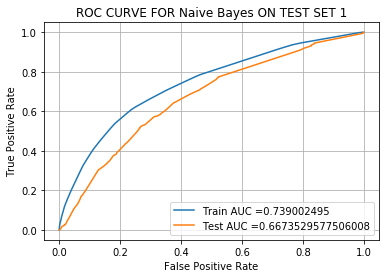

****************************************************************************************************

CONFUSION MATRIX FOR TRAIN DATA:
The maximum value of tpr*(1-fpr) is  0.46648987000000003 for threshold: 0.466
+------------+--------------+---------------+
|            | PREDICTED NO | PREDICTED YES |
+------------+--------------+---------------+
| ACTUAL NO  |    14854     |      5146     |
+------------+--------------+---------------+
| ACTUAL YES |     7438     |     12562     |
+------------+--------------+---------------+
****************************************************************************************************

CONFUSION MATRIX FOR TEST DATA:
The maximum value of tpr*(1-fpr) is  0.4010319584576477 for threshold: 0.462
+------------+--------------+---------------+
|            | PREDICTED NO | PREDICTED YES |
+------------+--------------+---------------+
| ACTUAL NO  |     948      |      566      |
+------------+--------------+---------------+
| ACTUAL YES |     3051 

In [0]:
y_train_pred = dt_model_1.predict_proba(train_set_1x)[:,1]
y_test_pred = dt_model_1.predict_proba(test_set_1x)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(train_set_1y, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(test_set_1y, y_test_pred)

tr_auc_1 = auc(train_fpr, train_tpr)
te_auc_1 = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(tr_auc_1))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(te_auc_1))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE FOR Naive Bayes ON TEST SET 1")
plt.grid()
plt.show()

print("*"*100+'\n')
print("CONFUSION MATRIX FOR TRAIN DATA:")
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
conf_mat = confusion_matrix(train_set_1y, predict_with_best_t(y_train_pred, best_t))
conf_table = PrettyTable()
conf_table.hrules = ALL
conf_table.field_names = ['', 'PREDICTED NO', 'PREDICTED YES']
conf_table.add_row(['ACTUAL NO', conf_mat[0][0], conf_mat[0][1]])
conf_table.add_row(['ACTUAL YES', conf_mat[1][0], conf_mat[1][1]])
print(conf_table)
print("*"*100+'\n')
print("CONFUSION MATRIX FOR TEST DATA:")
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
conf_mat = confusion_matrix(test_set_1y, predict_with_best_t(y_test_pred, best_t))
conf_table = PrettyTable()
conf_table.hrules = ALL
conf_table.field_names = ['', 'PREDICTED NO', 'PREDICTED YES']
conf_table.add_row(['ACTUAL NO', conf_mat[0][0], conf_mat[0][1]])
conf_table.add_row(['ACTUAL YES', conf_mat[1][0], conf_mat[1][1]])
print(conf_table)

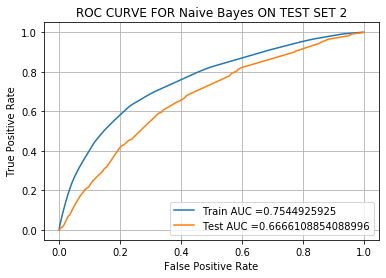

****************************************************************************************************

CONFUSION MATRIX FOR TRAIN DATA:
The maximum value of tpr*(1-fpr) is  0.48333824000000003 for threshold: 0.477
+------------+--------------+---------------+
|            | PREDICTED NO | PREDICTED YES |
+------------+--------------+---------------+
| ACTUAL NO  |    14336     |      5664     |
+------------+--------------+---------------+
| ACTUAL YES |     6514     |     13486     |
+------------+--------------+---------------+
****************************************************************************************************

CONFUSION MATRIX FOR TEST DATA:
The maximum value of tpr*(1-fpr) is  0.399423590210436 for threshold: 0.496
+------------+--------------+---------------+
|            | PREDICTED NO | PREDICTED YES |
+------------+--------------+---------------+
| ACTUAL NO  |     998      |      516      |
+------------+--------------+---------------+
| ACTUAL YES |     3344  

In [0]:
y_train_pred = dt_model_2.predict_proba(train_set_2x)[:,1]
y_test_pred = dt_model_2.predict_proba(test_set_2x)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(train_set_2y, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(test_set_2y, y_test_pred)

tr_auc_2 = auc(train_fpr, train_tpr)
te_auc_2 = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(tr_auc_2))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(te_auc_2))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE FOR Naive Bayes ON TEST SET 2")
plt.grid()
plt.show()

print("*"*100+'\n')
print("CONFUSION MATRIX FOR TRAIN DATA:")
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
conf_mat = confusion_matrix(train_set_2y, predict_with_best_t(y_train_pred, best_t))
conf_table = PrettyTable()
conf_table.hrules = ALL
conf_table.field_names = ['', 'PREDICTED NO', 'PREDICTED YES']
conf_table.add_row(['ACTUAL NO', conf_mat[0][0], conf_mat[0][1]])
conf_table.add_row(['ACTUAL YES', conf_mat[1][0], conf_mat[1][1]])
print(conf_table)
print("*"*100+'\n')
print("CONFUSION MATRIX FOR TEST DATA:")
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
conf_mat = confusion_matrix(test_set_2y, predict_with_best_t(y_test_pred, best_t))
conf_table = PrettyTable()
conf_table.hrules = ALL
conf_table.field_names = ['', 'PREDICTED NO', 'PREDICTED YES']
conf_table.add_row(['ACTUAL NO', conf_mat[0][0], conf_mat[0][1]])
conf_table.add_row(['ACTUAL YES', conf_mat[1][0], conf_mat[1][1]])
print(conf_table)

### 5.2 Plot features of false positive data points

We take the test data set 2 and create a new set with all the points for which prediction is false positive.

In [0]:
dataset_2 = test_set_2x.tocsr()
count = 0

original_labels = test_set_2y
predicted_labels = predict_with_best_t(y_test_pred, best_t)

for i in range(len(test_set_2y)):  
  if((original_labels[i]==0)&(predicted_labels[i]==1)):
    if count == 0 :
      fp_data = dataset_2[i]
      count += 1
    else:
      fp_data = sparse.vstack((fp_data, dataset_2[i]))

print(fp_data.shape)

(516, 5602)


So now we have the 516 false positive points (as validated by the confusion matrix) in a csr matrix. It has 5602 dimensions. Out of these, 


*   Prefix vectors: **5**
*   State vectors: **51**


*   Grade vectors: **4**
*   Category vectors: **9**


*   Subcategory vectors: **30**
*   **Price: 1**


*   Quantity: **1**
*   **Number of previous posts: 1**


*   Title TFIDF vector: **500**
*   **Essay TFIDF vector: 5000**

Thus *Price* is the 100th column in the above fp_data matrix. fp_data[:,99] as counting is from zero.
Also *Previous Posts* is the 102nd column. fp_data[:,101] as counting is from zero.
The last 5000 columns correspond to essay text data.











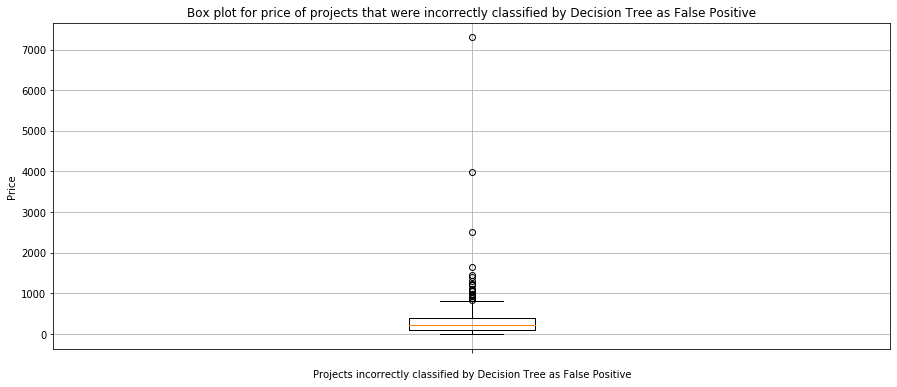

In [0]:
fp_price_std = fp_data[:,99]
fp_price_list = price_scalar.inverse_transform(fp_price_std.todense())

plt.figure(figsize=(15,6))
plt.boxplot(fp_price_list)
plt.title("Box plot for price of projects that were incorrectly classified by Decision Tree as False Positive")
plt.xlabel('Projects incorrectly classified by Decision Tree as False Positive')
plt.xticks([1], ' ')
plt.ylabel('Price')
plt.grid()
plt.show()

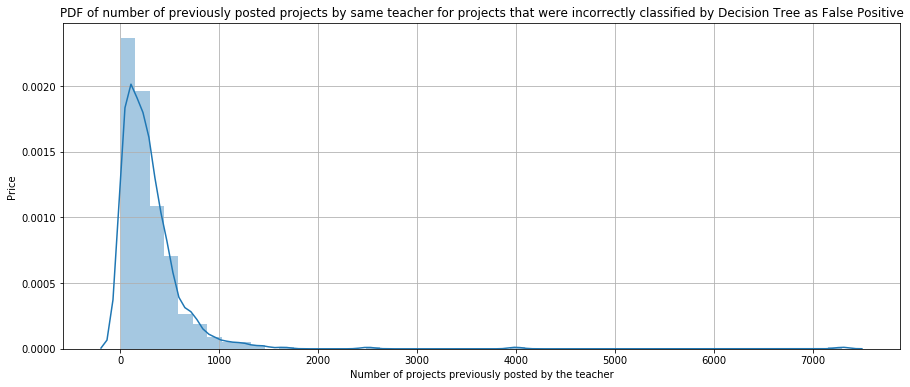

In [0]:
fp_pposts_std = fp_data[:,101]
fp_pposts_list = ppost_scalar.inverse_transform(fp_price_std.todense())

plt.figure(figsize=(15,6))
sns.distplot(fp_price_list, hist=True)
plt.title("PDF of number of previously posted projects by same teacher for projects that were incorrectly classified by Decision Tree as False Positive")
plt.xlabel('Number of projects previously posted by the teacher')
plt.ylabel('Price')
plt.grid()
plt.show()

In [0]:
fp_essays_enc = fp_data[:,-5000:]
fp_essays = tfidf_vectrzr_essay.inverse_transform(fp_essays_enc)

fp_essays_df = pd.DataFrame(fp_essays)

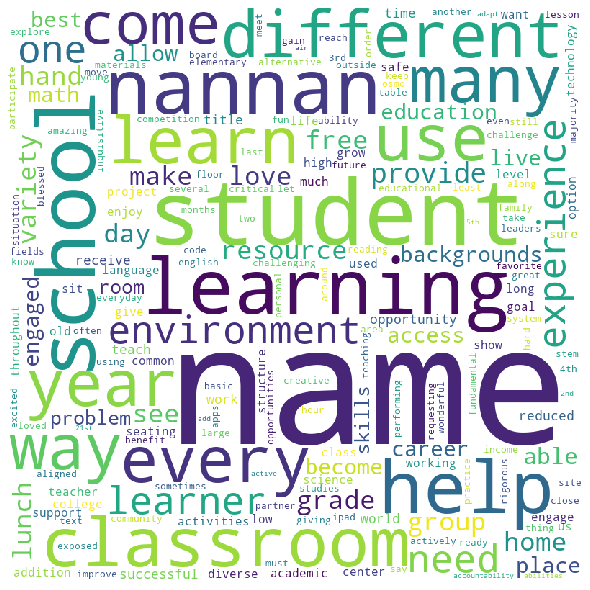

In [0]:
#Reference: https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud, STOPWORDS 

comment_words = ' '
stopwords = set(STOPWORDS)
stopwords.update(('dtype', 'none', 'object', 'length', 'nan'))                                        #strings introduced due to inverse transform operation

for _, val in fp_essays_df.iteritems():
  val = str(val) 
  tokens = val.split() 
      
  for i in range(len(tokens)): 
    tokens[i] = tokens[i].lower() 
          
  for words in tokens: 
    comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

## 6. Feature Importance based LR Model

### 6.1 Creating the dataset with important features:

In [0]:
f_imps = dt_model_1.feature_importances_

trainset_1 = train_set_1x.tocsr()
testset_1 = test_set_1x.tocsr()
count = 0

for i in range(len(f_imps)):  
  if(f_imps[i] != 0):
    if count == 0 :
      f_imp_train = trainset_1[:, i]
      f_imp_test = testset_1[:, 1]
      count += 1
    else:
      f_imp_train = sparse.hstack((f_imp_train, trainset_1[:, i]))
      f_imp_test = sparse.hstack((f_imp_test, testset_1[:, i]))

print(f_imp_train.shape)
print(f_imp_test.shape)

(40000, 78)
(10000, 78)


### 6.2 Training a Logistic Regression model on selected features

#### 6.2.1 Hyper-parameter tuning

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  27 out of  30 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed:    1.8s finished


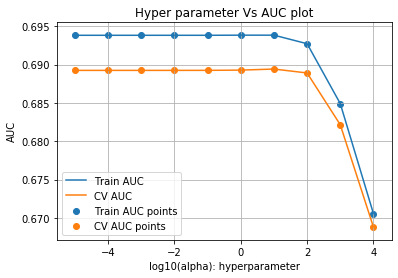

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
3,0.245029,0.001593,0.006668,0.000276,0.1,{'C': 0.1},0.693468,0.692215,0.682546,0.689410,0.004880,1,0.692353,0.692216,0.696923,0.693831,0.002187
4,0.286008,0.009200,0.006772,0.000090,1,{'C': 1},0.693355,0.692021,0.682440,0.689272,0.004861,2,0.692348,0.692226,0.696912,0.693829,0.002181


In [0]:
lr_model = LogisticRegression(class_weight='balanced')
parameters = {'C':[10**x for x in range(-4, 6)]}
clf = RandomizedSearchCV(lr_model, parameters, cv=3, n_iter=10, scoring='roc_auc', verbose=2, return_train_score=True, n_jobs=10)
clf.fit(f_imp_train, train_set_1y)

results = pd.DataFrame.from_dict(clf.cv_results_)
results_plt = results.sort_values(['param_C'])
results = results.sort_values(['mean_test_score'], ascending=False)

train_auc= results_plt['mean_train_score']

cv_auc = results_plt['mean_test_score'] 

K =  results_plt['param_C']

K = K.map(lambda c: math.log10(1/c))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log10(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head(2)

In [0]:
C = 0.1

#### 6.2.2 Apply LR to important feature dataset

In [0]:
lr_model = LogisticRegression(C=C, class_weight='balanced')
lr_model.fit(f_imp_train, train_set_1y)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### 6.3 Test Model

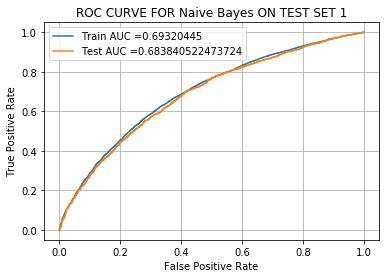

****************************************************************************************************

CONFUSION MATRIX FOR TRAIN DATA:
The maximum value of tpr*(1-fpr) is  0.41689288500000005 for threshold: 0.491
+------------+--------------+---------------+
|            | PREDICTED NO | PREDICTED YES |
+------------+--------------+---------------+
| ACTUAL NO  |    13241     |      6759     |
+------------+--------------+---------------+
| ACTUAL YES |     7406     |     12594     |
+------------+--------------+---------------+
****************************************************************************************************

CONFUSION MATRIX FOR TEST DATA:
The maximum value of tpr*(1-fpr) is  0.4086189359675786 for threshold: 0.467
+------------+--------------+---------------+
|            | PREDICTED NO | PREDICTED YES |
+------------+--------------+---------------+
| ACTUAL NO  |     888      |      626      |
+------------+--------------+---------------+
| ACTUAL YES |     2574 

In [0]:
y_train_pred = lr_model.predict_proba(f_imp_train)[:,1]
y_test_pred = lr_model.predict_proba(f_imp_test)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(train_set_1y, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(test_set_1y, y_test_pred)

lr_tr_auc = auc(train_fpr, train_tpr)
lr_te_auc = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(lr_tr_auc))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(lr_te_auc))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE FOR Naive Bayes ON TEST SET 1")
plt.grid()
plt.show()

print("*"*100+'\n')
print("CONFUSION MATRIX FOR TRAIN DATA:")
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
conf_mat = confusion_matrix(train_set_1y, predict_with_best_t(y_train_pred, best_t))
conf_table = PrettyTable()
conf_table.hrules = ALL
conf_table.field_names = ['', 'PREDICTED NO', 'PREDICTED YES']
conf_table.add_row(['ACTUAL NO', conf_mat[0][0], conf_mat[0][1]])
conf_table.add_row(['ACTUAL YES', conf_mat[1][0], conf_mat[1][1]])
print(conf_table)
print("*"*100+'\n')
print("CONFUSION MATRIX FOR TEST DATA:")
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
conf_mat = confusion_matrix(test_set_1y, predict_with_best_t(y_test_pred, best_t))
conf_table = PrettyTable()
conf_table.hrules = ALL
conf_table.field_names = ['', 'PREDICTED NO', 'PREDICTED YES']
conf_table.add_row(['ACTUAL NO', conf_mat[0][0], conf_mat[0][1]])
conf_table.add_row(['ACTUAL YES', conf_mat[1][0], conf_mat[1][1]])
print(conf_table)

## 7. Summary table 

In [0]:
from prettytable import PrettyTable

summ = PrettyTable()

summ.field_names = ["Dataset", "Model", "Hyperparameter", "AUC on Test data"]

summ.add_row(["BOW vectorized", "Decison Tree Classifier", "Max_depth: "+str(D_1)+"\nMin_sample_split: "+str(S_1), np.round(te_auc_1, 4)])
summ.add_row(["TFIDF vectorized", "Decison Tree Classifier", "Max_depth: "+str(D_2)+"\nMin_sample_split: "+str(S_2), np.round(te_auc_2, 4)])
summ.add_row(["Important Features Selected", "Logistic Regression", "C: "+str(C), np.round(lr_te_auc, 4)])
summ.hrules = ALL

print(summ)

+-----------------------------+-------------------------+-----------------------+------------------+
|           Dataset           |          Model          |     Hyperparameter    | AUC on Test data |
+-----------------------------+-------------------------+-----------------------+------------------+
|        BOW vectorized       | Decison Tree Classifier |     Max_depth: 10     |      0.6674      |
|                             |                         | Min_sample_split: 500 |                  |
+-----------------------------+-------------------------+-----------------------+------------------+
|       TFIDF vectorized      | Decison Tree Classifier |     Max_depth: 10     |      0.6666      |
|                             |                         | Min_sample_split: 500 |                  |
+-----------------------------+-------------------------+-----------------------+------------------+
| Important Features Selected |   Logistic Regression   |         C: 0.1        |      0.68

**SUMMARY:** The above results demonstrate that decison tree algorithms are better for feature selection than for actual classification on complex datasets.